In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive

### Data Processing

In [2]:
scaler = StandardScaler()

In [3]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [4]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [5]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [6]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(10000)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(2000)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()


# df_rest_features

In [9]:
df_rest_02 = df_rest_features.drop(index = df_test_target_index).reset_index()
df_rest_02 = df_rest_02.drop(columns = {df_rest_02.columns[0]})
df_val_target = df_rest_02[['Class']].sample(200)
df_val_target_index = df_val_target.index

df_val_features = df_rest_02.iloc[df_val_target_index]
df_val_features = df_val_features.drop(columns={'Class'}).to_numpy()

df_val_target = df_val_target.to_numpy()
df_val_features.shape, df_val_target.shape

((200, 14), (200, 1))

In [10]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=5
tau=10

### Ancestral Sampling 

In [11]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.91148511 -1.19001836  0.9402201   0.97409749  2.13239589 -0.30328903
 -0.15495145 -0.04100737  0.80890962  0.56301712  0.76956412 -0.75473861
 -0.38065656 -1.14257806]


In [12]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [13]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({10.0: 1237,
         2.0: 1205,
         4.0: 1366,
         8.0: 1273,
         5.0: 336,
         6.0: 1540,
         0.0: 862,
         7.0: 301,
         9.0: 373,
         3.0: 1234,
         1.0: 273})

In [14]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.0873


### Model implementation with Pyro

In [15]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                   loc=torch.zeros(n_cat), 
                                                   scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [16]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Parameter Tuning

##### Degree of Freedom

In [18]:
degF_range = [4,5,6]

acc_val_degF = []


for degF in degF_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    
    print({degF:acc})
    acc_val_degF.append({degF:acc})
   

[0] ELBO: 256817.8
[1000] ELBO: 183559.9
[2000] ELBO: 133479.6
[3000] ELBO: 90728.7
[4000] ELBO: 58785.6
[5000] ELBO: 39428.3
[6000] ELBO: 26343.6
[7000] ELBO: 20710.9
[8000] ELBO: 17398.4
[9000] ELBO: 15470.1
[10000] ELBO: 14550.5
[11000] ELBO: 14268.3
[12000] ELBO: 14205.5
[13000] ELBO: 14173.1
[14000] ELBO: 14154.3
[15000] ELBO: 14134.8
[16000] ELBO: 14145.3
[17000] ELBO: 14137.5
[18000] ELBO: 14124.0
[19000] ELBO: 14112.5


C:\Users\user\AppData\Local\Temp\ipykernel_6972\2123264113.py:45: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  mean_alpha = mean_alpha.T


{4: 0.46}
[0] ELBO: 198153.5
[1000] ELBO: 127704.1
[2000] ELBO: 79642.9
[3000] ELBO: 49298.4
[4000] ELBO: 30887.4
[5000] ELBO: 22197.8
[6000] ELBO: 17541.0
[7000] ELBO: 14816.4
[8000] ELBO: 14289.0
[9000] ELBO: 14177.3
[10000] ELBO: 14133.4
[11000] ELBO: 14088.9
[12000] ELBO: 14081.0
[13000] ELBO: 14072.2
[14000] ELBO: 14062.3
[15000] ELBO: 14054.6
[16000] ELBO: 14061.3
[17000] ELBO: 14041.0
[18000] ELBO: 14029.0
[19000] ELBO: 14036.2
{5: 0.46}
[0] ELBO: 231608.2
[1000] ELBO: 168205.5
[2000] ELBO: 116104.5
[3000] ELBO: 79998.1
[4000] ELBO: 56066.6
[5000] ELBO: 41905.7
[6000] ELBO: 32127.6
[7000] ELBO: 26631.4
[8000] ELBO: 21888.4
[9000] ELBO: 18062.6
[10000] ELBO: 15289.0
[11000] ELBO: 14368.5
[12000] ELBO: 14191.0
[13000] ELBO: 14181.3
[14000] ELBO: 14160.1
[15000] ELBO: 14151.9
[16000] ELBO: 14151.9
[17000] ELBO: 14129.8
[18000] ELBO: 14136.9
[19000] ELBO: 14129.5
{6: 0.47}


In [19]:
acc_val_degF

[{4: 0.46}, {5: 0.46}, {6: 0.47}]

##### Tau in Variance

In [20]:
tau_range = [1,10,50,100]

acc_val_tau = []


for tau in tau_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({tau:acc})
    acc_val_tau.append({tau:acc})
   

[0] ELBO: 41817.3
[1000] ELBO: 16568.2
[2000] ELBO: 14540.2
[3000] ELBO: 14137.8
[4000] ELBO: 14073.7
[5000] ELBO: 14027.4
[6000] ELBO: 13996.6
[7000] ELBO: 13961.7
[8000] ELBO: 13961.6
[9000] ELBO: 13948.3
[10000] ELBO: 13933.6
[11000] ELBO: 13935.1
[12000] ELBO: 13940.3
[13000] ELBO: 13927.6
[14000] ELBO: 13921.5
[15000] ELBO: 13917.0
[16000] ELBO: 13910.5
[17000] ELBO: 13917.5
[18000] ELBO: 13907.1
[19000] ELBO: 13907.9
{1: 0.47}
[0] ELBO: 222154.5
[1000] ELBO: 146415.7
[2000] ELBO: 89711.7
[3000] ELBO: 49488.9
[4000] ELBO: 26798.7
[5000] ELBO: 19928.9
[6000] ELBO: 16033.7
[7000] ELBO: 14695.4
[8000] ELBO: 14300.0
[9000] ELBO: 14192.8
[10000] ELBO: 14133.8
[11000] ELBO: 14113.7
[12000] ELBO: 14105.4
[13000] ELBO: 14094.1
[14000] ELBO: 14082.4
[15000] ELBO: 14080.9
[16000] ELBO: 14089.7
[17000] ELBO: 14077.0
[18000] ELBO: 14066.7
[19000] ELBO: 14078.9
{10: 0.465}
[0] ELBO: 904804.4
[1000] ELBO: 824127.4
[2000] ELBO: 756838.2
[3000] ELBO: 694322.7
[4000] ELBO: 623243.4
[5000] ELBO: 58

In [21]:
acc_val_tau

[{1: 0.47}, {10: 0.465}, {50: 0.275}, {100: 0.175}]

### Model implementation with Pyro V2

In [22]:
def model_2(X, n_cat,lambda_, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.Normal(torch.zeros(n_cat), 
                                            lambda_*torch.ones(n_cat)).to_event()) # Prior for the bias mean  
    
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

##### lambda

In [23]:
lambda_range = [1,5,10]

acc_val_lambda = []


for lambda_ in lambda_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model_2)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model_2, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, lambda_, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, lambda_, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({lambda_:acc})
    acc_val_lambda.append({lambda_:acc})
   

[0] ELBO: 1717857.8
[1000] ELBO: 1646307.5
[2000] ELBO: 1572020.9
[3000] ELBO: 1507262.8
[4000] ELBO: 1442426.8
[5000] ELBO: 1377067.8
[6000] ELBO: 1307299.9
[7000] ELBO: 1252964.5
[8000] ELBO: 1192005.1
[9000] ELBO: 1144120.8
[10000] ELBO: 1089628.6
[11000] ELBO: 1026439.4
[12000] ELBO: 978914.2
[13000] ELBO: 937800.3
[14000] ELBO: 885315.9
[15000] ELBO: 850040.4
[16000] ELBO: 803468.7
[17000] ELBO: 764217.2
[18000] ELBO: 730751.8
[19000] ELBO: 701448.0
{1: 0.17}
[0] ELBO: 2437974.1
[1000] ELBO: 2356534.2
[2000] ELBO: 2283290.8
[3000] ELBO: 2215982.3
[4000] ELBO: 2135376.9
[5000] ELBO: 2067831.5
[6000] ELBO: 1993320.8
[7000] ELBO: 1917355.3
[8000] ELBO: 1852659.0
[9000] ELBO: 1787957.3
[10000] ELBO: 1719588.6
[11000] ELBO: 1655942.4
[12000] ELBO: 1590818.8
[13000] ELBO: 1534655.9
[14000] ELBO: 1465780.7
[15000] ELBO: 1423100.9
[16000] ELBO: 1362733.3
[17000] ELBO: 1315760.1
[18000] ELBO: 1240601.6
[19000] ELBO: 1208568.2
{5: 0.115}
[0] ELBO: 2082054.1
[1000] ELBO: 2005748.4
[2000] ELB

#### Final Model training 

In [24]:
degF=5
tau=1

In [25]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 40756.0
[1000] ELBO: 19853.6
[2000] ELBO: 15486.0
[3000] ELBO: 14423.4
[4000] ELBO: 14153.3
[5000] ELBO: 14058.3
[6000] ELBO: 14030.1
[7000] ELBO: 14000.3
[8000] ELBO: 13972.4
[9000] ELBO: 13964.2
[10000] ELBO: 13965.9
[11000] ELBO: 13945.3
[12000] ELBO: 13936.3
[13000] ELBO: 13952.2
[14000] ELBO: 13922.6
[15000] ELBO: 13927.5
[16000] ELBO: 13934.3
[17000] ELBO: 13914.1
[18000] ELBO: 13911.0
[19000] ELBO: 13909.4


In [26]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

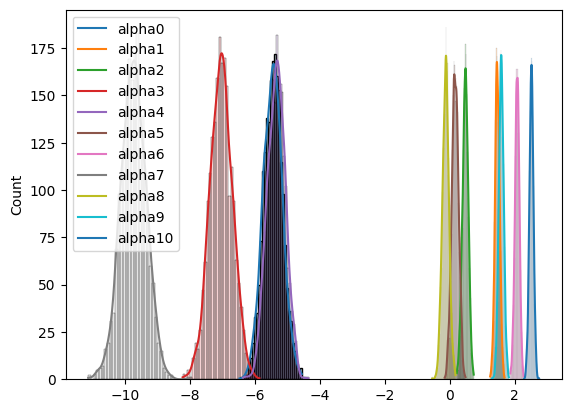

In [27]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

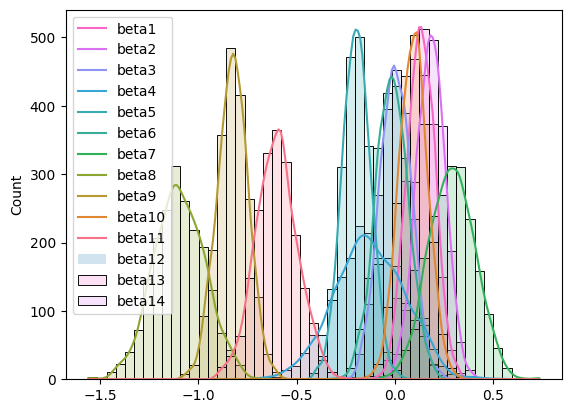

In [28]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [29]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [30]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [0.09260889 0.03366465 0.00712931 0.00563469 0.5052372  0.00520694
 0.04153489 0.00199886 0.00109505 0.20024    0.10564951] 4.0
n, p and y  1 [1.14061975e-05 1.19650548e-01 1.71501442e-02 2.98910627e-07
 1.10993872e-04 7.87352837e-03 1.31971461e-01 1.86590339e-08
 1.02028754e-01 4.02046975e-02 5.80998150e-01] 10.0
n, p and y  2 [4.82639986e-03 7.85291900e-02 5.57313867e-02 8.80790546e-05
 1.70487484e-03 2.37167761e-02 2.45424035e-01 5.85705457e-04
 2.76395112e-04 4.64067490e-01 1.25049668e-01] 9.0
n, p and y  3 [4.40364370e-06 7.39055423e-02 2.21320281e-02 9.06940676e-07
 9.64407800e-05 2.95962537e-02 9.56772208e-02 3.08391999e-08
 6.55467337e-02 1.72721754e-01 5.40318685e-01] 10.0
n, p and y  4 [8.12855430e-02 3.77878708e-02 7.69967702e-02 2.36128649e-02
 1.48248686e-03 1.02555393e-02 1.10727517e-01 9.87900536e-03
 1.07137501e-04 5.90923503e-01 5.69417621e-02] 9.0
n, p and y  5 [2.38620018e-06 9.07084563e-02 7.35490962e-03 9.76264477e-07
 1.04100620e-05 1.77703460e-03 5.

In [31]:
y_train_pred = y_train_pred[:,0]

In [32]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.4945


### Inference and computation of accuracy on the test dataset 

In [33]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_test_pred[n,:])

n, p and y  0 [8.21141662e-06 1.13674463e-01 8.30599078e-03 2.57479325e-07
 1.46090973e-04 1.88840422e-02 1.50138684e-01 2.76292815e-08
 1.01691651e-01 1.25515706e-01 4.81634876e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  1 [2.01686064e-05 8.28854339e-02 1.63570485e-01 3.44504630e-04
 1.25867539e-05 3.61372726e-02 1.36430239e-01 3.58208274e-08
 3.62908466e-02 1.77681462e-01 3.66626965e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  2 [8.44507908e-01 9.73143467e-04 1.85011014e-03 7.11257151e-02
 3.77391325e-02 4.06750456e-05 2.18906213e-03 1.81250649e-02
 6.31614982e-06 2.11267909e-02 2.31608198e-03] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
n, p and y  3 [2.90073201e-04 7.94316052e-02 8.92298058e-03 8.76448619e-06
 3.00841257e-04 8.06048710e-02 1.60764738e-01 4.77891925e-06
 2.17994278e-02 4.56969403e-01 1.90902518e-01] [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
n, p and y  4 [8.29790518e-05 1.27351808e-01 2.39853017e-02 1.04514502e-05
 5.24998196e-05 3.26552081e-02 

In [34]:
y_test_pred = y_test_pred[:,0]

In [35]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.499



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 
* Consider different distributions for priors

Done

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Train model on more data - currently 100 

TODO

* Feature engineer name and album name and retrain logistic regression model using these attributes
* Hyper parameter tuning
* Extend it with FFNN 
* Train model on more data (like 10000)